In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


In [3]:
def plot_bar(column):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

    # temp df 
    temp_1 = pd.DataFrame()
    temp_2 = pd.DataFrame()
    # count categorical values
    temp_1['Yes'] = data_C[data_C['y'] == 1][column].value_counts()
    temp_1['No'] = data_C[data_C['y'] == 0][column].value_counts()
    temp_1.plot(kind='bar', ax=ax[0])
    ax[0].set_xlabel(f'{column}')
    ax[0].set_ylabel('Number of clients')
    ax[0].set_title('C sample; Distribution of "{}"'.format(column))

    temp_2['Yes'] = data_T[data_T['y'] == 1][column].value_counts()
    temp_2['No'] = data_T[data_T['y'] == 0][column].value_counts()
    temp_2.plot(kind='bar', ax=ax[1])
    ax[1].set_xlabel(f'{column}')
    ax[1].set_ylabel('Number of clients')
    ax[1].set_title('T sample; Distribution of "{}"'.format(column))
    plt.tight_layout()

    plt.show();


In [4]:
data = pd.read_csv('Data/WolliesX_DataScience_Test_data.csv')

# DATASET INSPECTION

A general inspection of the dataset is useful to get more familiar with the type of features and to identify which are the numerical columns and the object columns.

In [5]:
data.head()

,age,job,marital,education,default,housing,loan,campaign,contact,month,day_of_week,duration,previous,poutcome,cons.price.idx,cons.conf.idx,y
0,56,housemaid,married,basic.4y,no,no,no,1,telephone,may,mon,261,0,nonexistent,93.994,-36.4,no
1,57,services,married,high.school,unknown,no,no,1,telephone,may,mon,149,0,nonexistent,93.994,-36.4,no
2,37,services,married,high.school,no,yes,no,1,telephone,may,mon,226,0,nonexistent,93.994,-36.4,no
3,40,admin.,married,basic.6y,no,no,no,1,telephone,may,mon,151,0,nonexistent,93.994,-36.4,no
4,56,services,married,high.school,no,no,yes,1,telephone,may,mon,307,0,nonexistent,93.994,-36.4,no


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   campaign        41188 non-null  int64  
 8   contact         17642 non-null  object 
 9   month           17642 non-null  object 
 10  day_of_week     17642 non-null  object 
 11  duration        41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  y               41188 non-null  object 
dtypes: float64(2), int64(4), object

### Target feature
I want a numerical target column.

In [7]:
data["y"] = data["y"].map({"no":0, "yes":1})


### Control and Treatment samples
Divide the datasets in two samples. <br />
1) Control sample (C): clients that have not participated to the marketing campain.<br />
2) Treatment sample (T) : clients that have participated to the marketing campain.<br />

In [8]:
f = data.campaign == 1
data_C = data[~f] #control sample
data_T = data[f] #treatment sample


### Relevant features
From T, I drop the feature "campaign". It has been already used to devide the samples in T and C.<br />

From C, I also drop "day_of_week", "month", and "duration" because these clients have not participated to the campaign.

In [10]:
data_C = data_C.drop(['campaign','duration','contact','month','day_of_week'], axis=1)
data_T = data_T.drop(['campaign'], axis=1) # I also drop "duration" (data leackage)

print("Shape C: {}".format(data_C.shape))
print("Shape T: {}".format(data_T.shape))

Shape C: (23546, 12)
Shape T: (17642, 16)


### Null values?

In [146]:
print("Does C contain null values? {}".format(data_C.isnull().values.any()))
print("Does T contain null values? {}".format(data_T.isnull().values.any()))

Does C contain null values? False
Does T contain null values? False


### Duplicated rows?


In [147]:
print("Does C contain duplicated rows? {}".format(data_C.duplicated().any()))
print("How many? {}".format(len(data_C[data_C.duplicated() == True])))

print("Does T contain duplicated rows? {}".format(data_T.duplicated().any()))
print("How many? {}".format(len(data_T[data_T.duplicated() == True])))


Does C contain duplicated rows? True
How many? 5741
Does T contain duplicated rows? True
How many? 9


There are many duplicated rows! It is curious that the C sample contains many more duplicated rows than T. Communication is important, so under normal circumstances I would ask a clarification to the people that have collected these data: are the duplicated rows an error or not? <br />

The fact that T, which is a more controlled sample, has very few duplications makes me think that it is an error. So, for this exercise I decide to drop the duplications.

In [148]:
print("C sample")
print("Shape before: {}".format(data_C.shape))
data_C = data_C.drop_duplicates()
print("Shape after: {}".format(data_C.shape))
print("")
print("T sample")
print("Shape before: {}".format(data_T.shape))
data_T = data_T.drop_duplicates()
print("Shape after: {}".format(data_T.shape))


C sample
Shape before: (23546, 12)
Shape after: (17805, 12)

T sample
Shape before: (17642, 16)
Shape after: (17633, 16)


## Feature inspection

First, I start inspecting the features that are in common between the C and T samples. Then I will inspect the features that are characteristic of sample T only.

### JOB
From the analysis of this feature results that students and retired are more likely to buy the credit card both in the C and T samples.
On the other hand, blue-collars and entrepreneurs seem "lost causes". 

In [104]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['job'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['job'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
job,,
student,0.689320,0.310680
retired,0.760429,0.239571
admin.,0.842996,0.157004
unemployed,0.866534,0.133466
technician,0.872386,0.127614
management,0.879500,0.120500
self-employed,0.894665,0.105335
services,0.898790,0.101210
housemaid,0.900376,0.099624


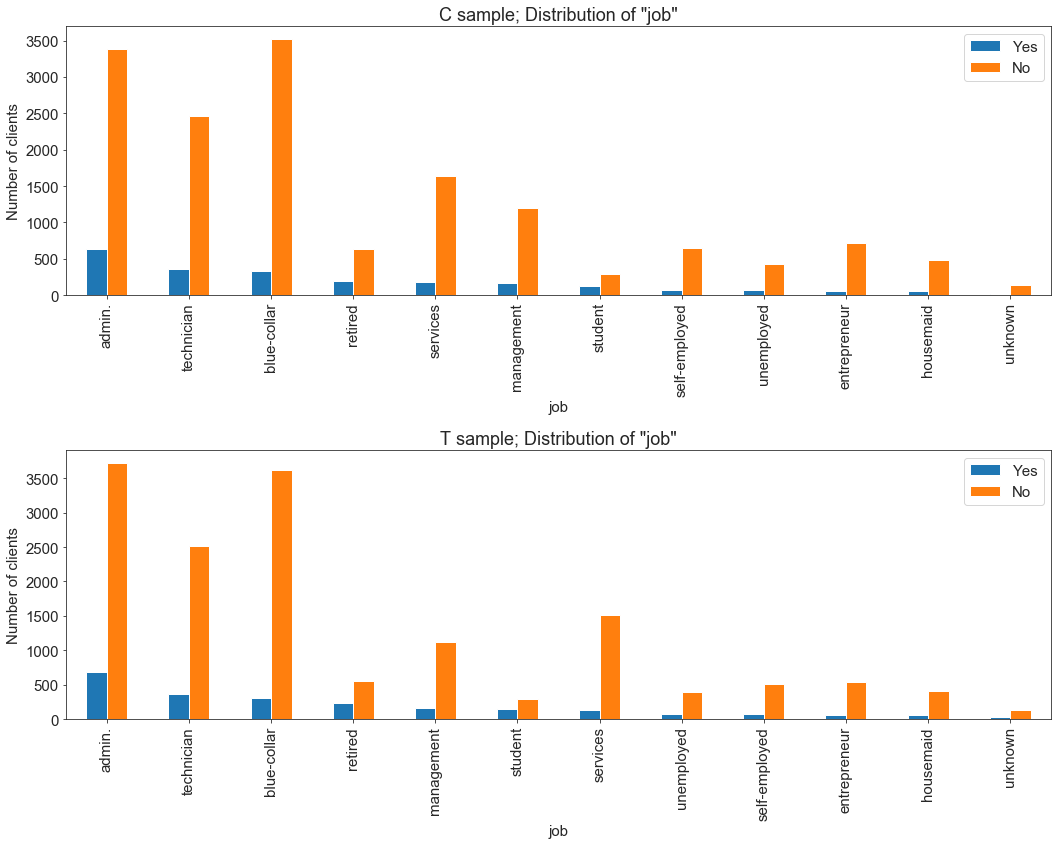

In [165]:
plot_bar("job")


## Marital

Single people are more likely to buy, maybe because they have more money to spend. People with marital status equal to "unknow" are very few, so their statistic is not reliable.

In [105]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['marital'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['marital'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
marital,,
single,0.845507,0.154493
married,0.881038,0.118962
divorced,0.890558,0.109442
unknown,0.930233,0.069767
y,0,1
marital,,
unknown,0.777778,0.222222
single,0.834862,0.165138
married,0.883368,0.116632


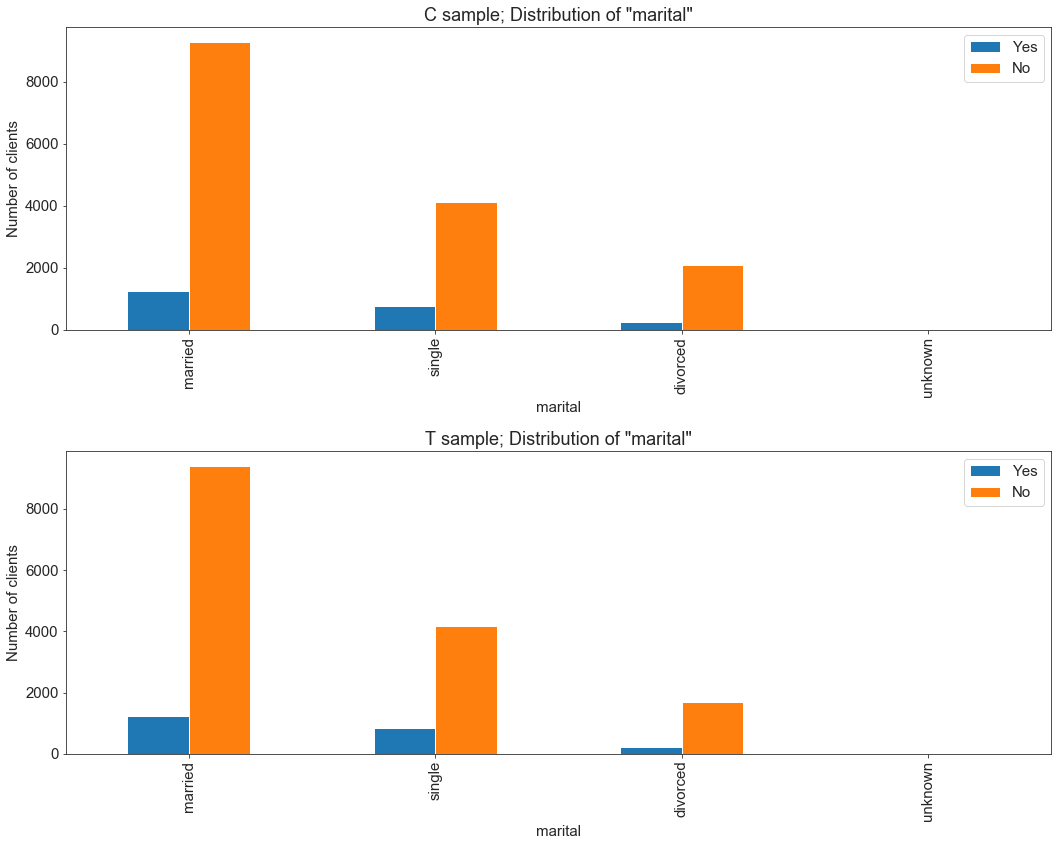

In [166]:
plot_bar("marital")


## Education

Clients with a university degree are more likely to buy the product. On the other hand, clients with a basic instruction are less likely. This is true for both the C and T samples.

In [136]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['education'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['education'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
education,,
illiterate,0.800000,0.200000
university.degree,0.838025,0.161975
unknown,0.870968,0.129032
professional.course,0.871928,0.128072
high.school,0.878511,0.121489
basic.4y,0.887061,0.112939
basic.6y,0.901189,0.098811
basic.9y,0.908214,0.091786
y,0,1


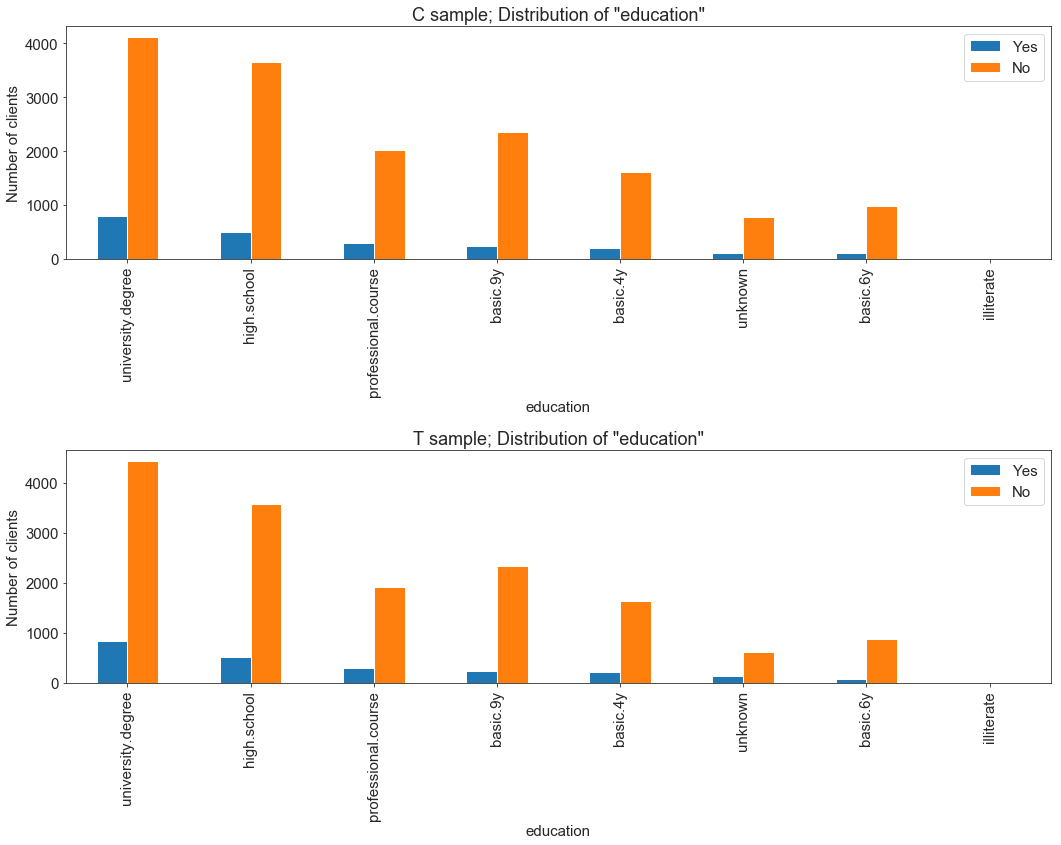

In [167]:
plot_bar("education")


## Default

No default preferred.

In [149]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['default'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['default'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
default,,
no,0.851354,0.148646
unknown,0.942119,0.057881
yes,1.000000,0.000000
y,0,1
default,,
no,0.851530,0.148470
unknown,0.943103,0.056897
yes,1.000000,0.000000


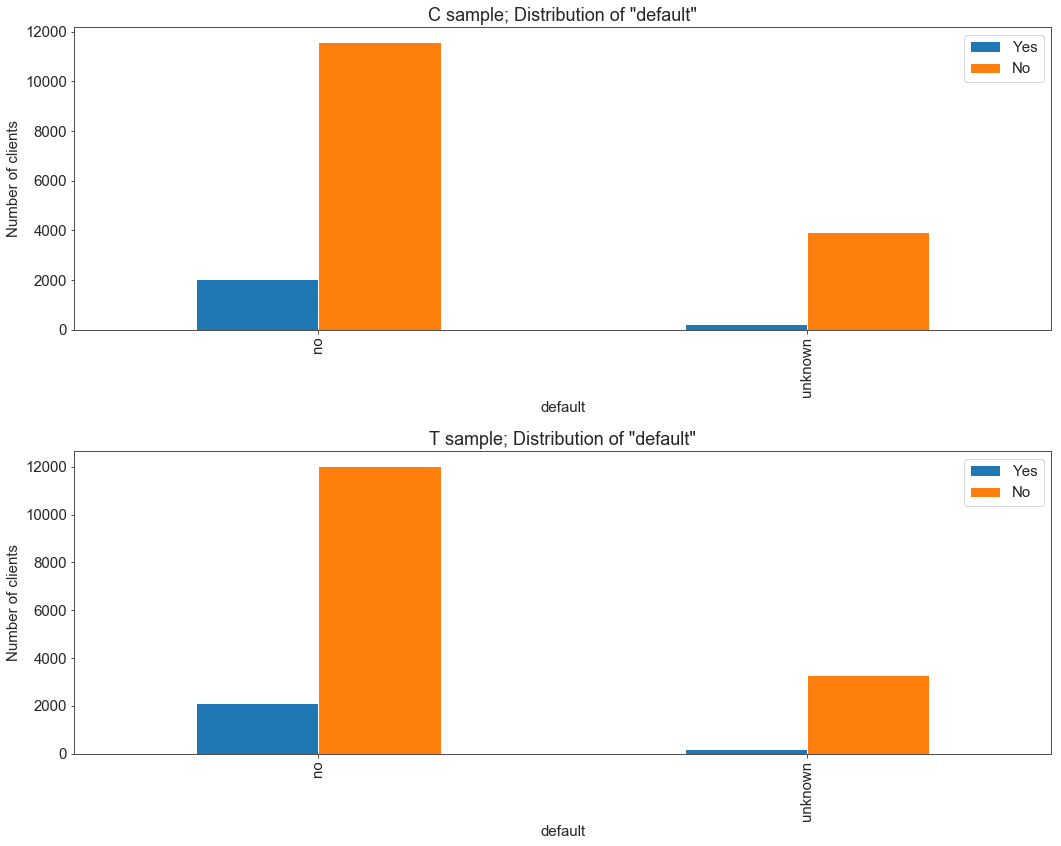

In [168]:
plot_bar("default")


## Housing

No clear relation between the feature and the target.

In [169]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['housing'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['housing'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
housing,,
yes,0.865468,0.134532
no,0.877958,0.122042
unknown,0.915162,0.084838
y,0,1
housing,,
unknown,0.855422,0.144578
yes,0.868654,0.131346
no,0.871518,0.128482


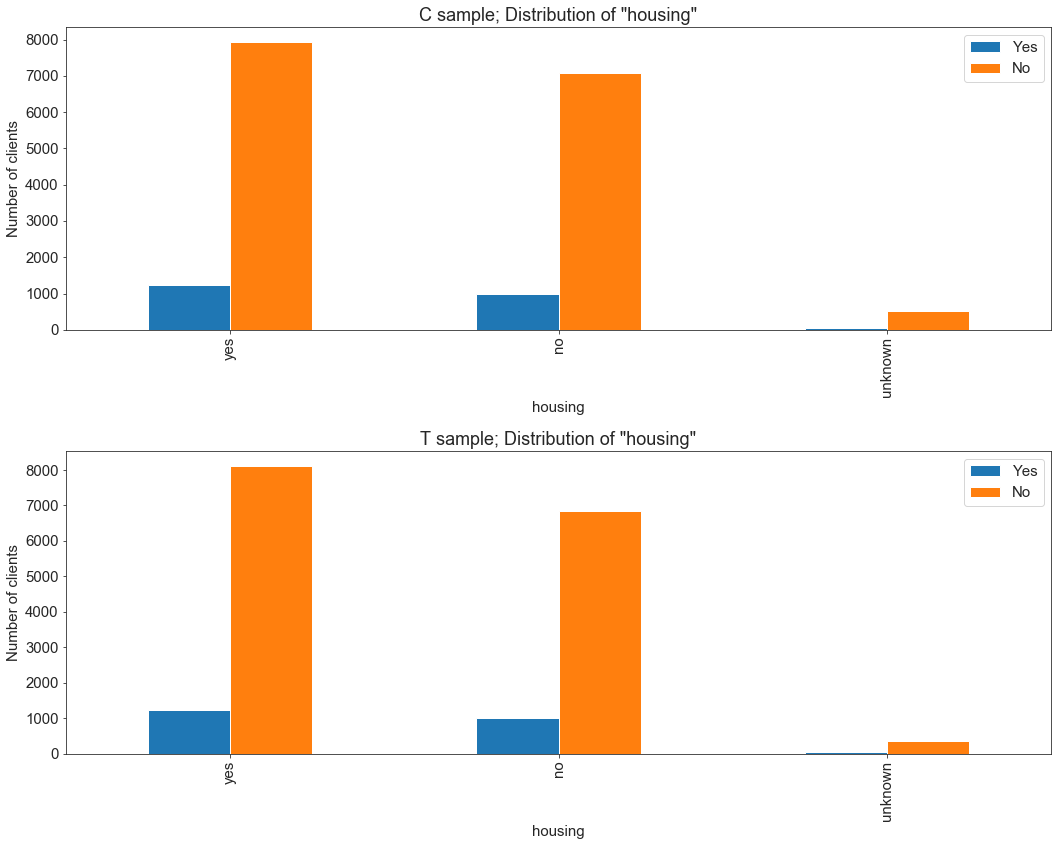

In [170]:
plot_bar("housing")


## Loan

No clear relation between the feature and the target.

In [153]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['loan'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['loan'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
loan,,
no,0.865701,0.134299
yes,0.894928,0.105072
unknown,0.915162,0.084838
y,0,1
loan,,
unknown,0.855422,0.144578
no,0.869515,0.130485
yes,0.872488,0.127512


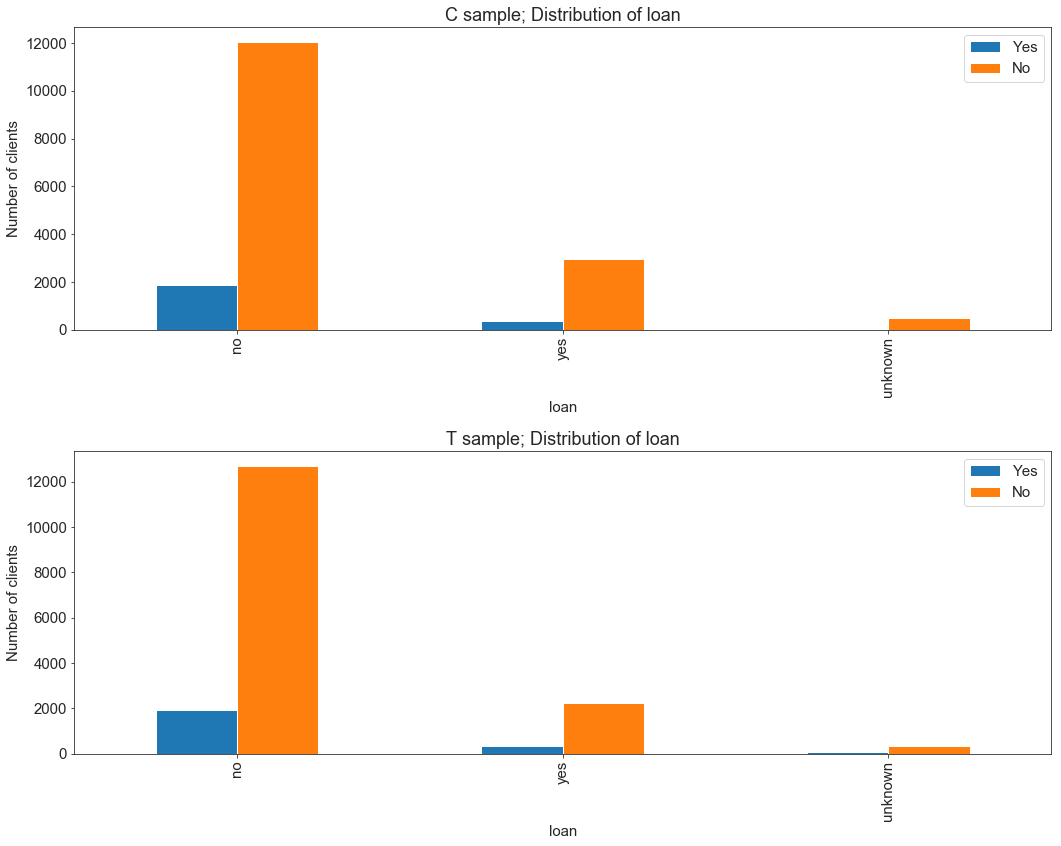

In [154]:
plot_bar("loan")


## Previous outcome

Clients that have participated with success in previous campaigns, are more likely to buy the credit card. This tells us that it is important to establish bonds with clients.

In [155]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['poutcome'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['poutcome'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
poutcome,,
success,0.374415,0.625585
failure,0.857719,0.142281
nonexistent,0.895666,0.104334
y,0,1
poutcome,,
success,0.327348,0.672652
failure,0.848613,0.151387
nonexistent,0.899202,0.100798


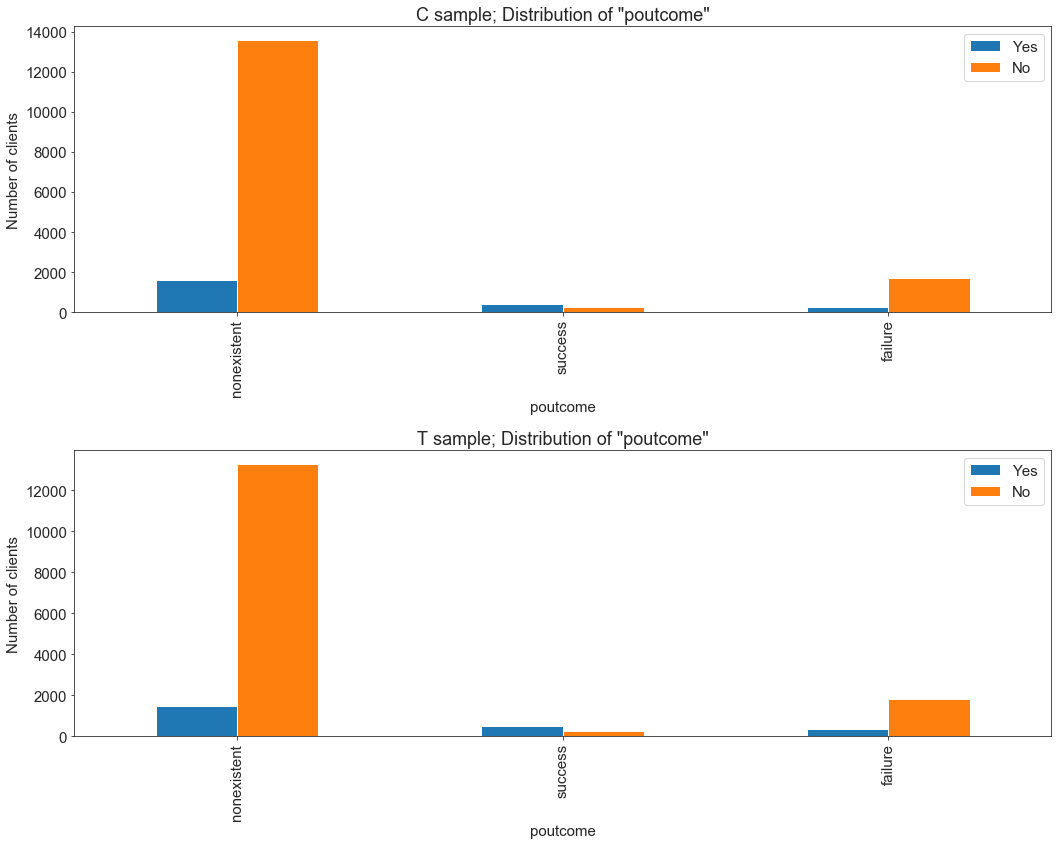

In [171]:
plot_bar("poutcome")


## Previous contacts

Clients that have been contacted many times in the past are more likely to buy the credit card. This confirms that it is important to establish bonds with the clients.

In [157]:
print("        C sample                     T sample")
t1 = pd.crosstab(data_C['previous'], data_C['y'], normalize='index').sort_values(by=1,ascending=False )
t2 = pd.crosstab(data_T['previous'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )
display_side_by_side(t1,t2)


        C sample                     T sample


y,0,1
previous,,
5,0.428571,0.571429
3,0.452830,0.547170
4,0.558824,0.441176
2,0.569061,0.430939
6,0.666667,0.333333
1,0.787305,0.212695
0,0.895666,0.104334
y,0,1
previous,,


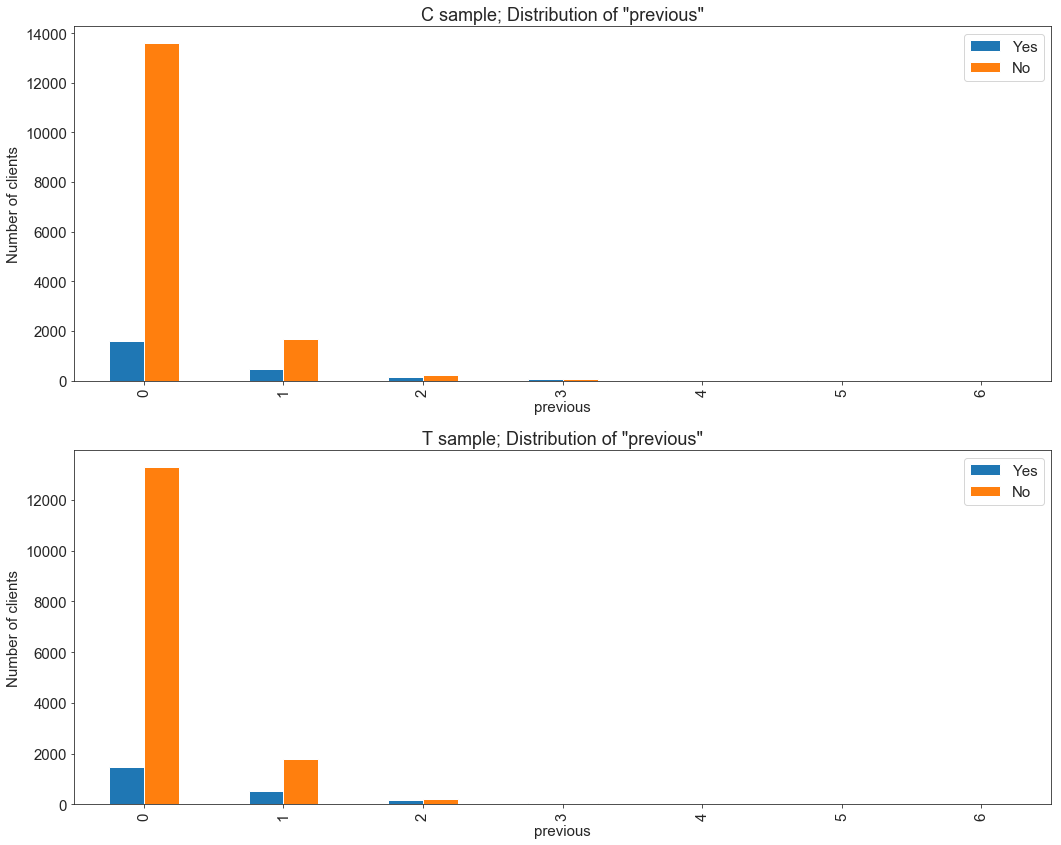

In [172]:
plot_bar("previous")


## Age

The clients that are most likely to buy the card are old (>60) and young (<30).
The number of clients of the bank drops at ages > 60. I don't know why, because old clients are good clients! Maybe it is something related to the "eligibility" to buy the product.



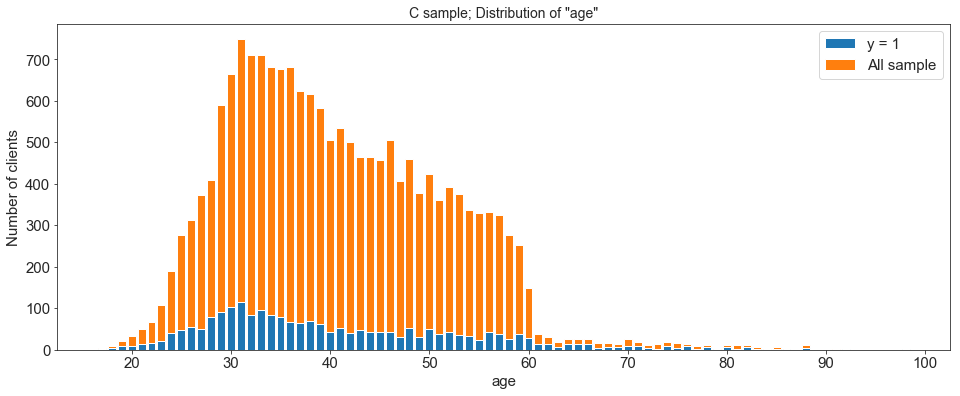

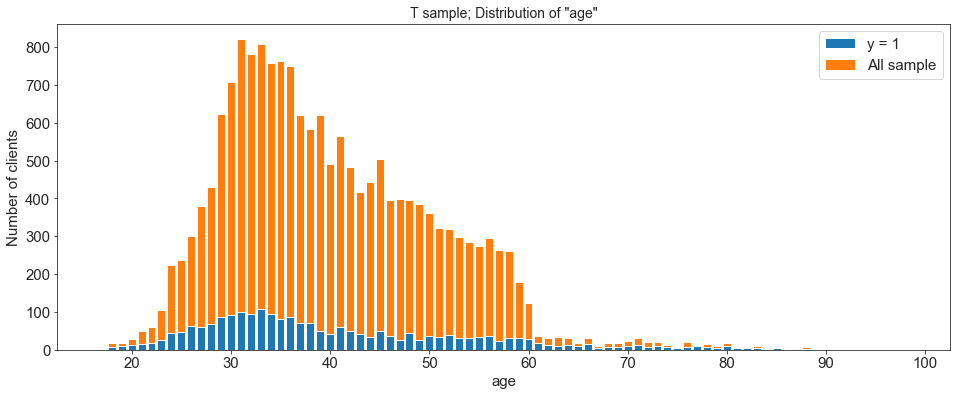

In [187]:
column = 'age'

ds = data_C
plt.figure(figsize=(16,6))
plt.bar(ds.groupby(column).y.sum().keys(), [ds[ds[column]==i].y.sum() for i in ds.groupby(column).y.sum().keys()], label='y = 1', zorder=2)
plt.bar(ds.groupby(column).y.sum().keys(), [sum(ds[column]==i) for i in ds.groupby(column).y.sum().keys()], label='All sample', zorder=0)
plt.title('C sample; Distribution of "{}"'.format(column), fontsize=14)
plt.xlabel(column)
plt.ylabel('Number of clients')
plt.legend()
plt.show()

ds = data_T
plt.figure(figsize=(16,6))
plt.bar(ds.groupby(column).y.sum().keys(), [ds[ds[column]==i].y.sum() for i in ds.groupby(column).y.sum().keys()], label='y = 1', zorder=2)
plt.bar(ds.groupby(column).y.sum().keys(), [sum(ds[column]==i) for i in ds.groupby(column).y.sum().keys()], label='All sample', zorder=0)
plt.title('T sample; Distribution of "{}"'.format(column), fontsize=14)
plt.xlabel(column)
plt.ylabel('Number of clients')
plt.legend()
plt.show()


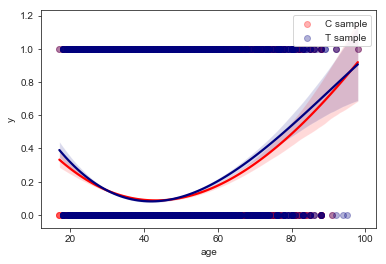

In [240]:
sns.regplot(x="age", y="y", order=3, data=data_C, truncate=True, scatter_kws={'alpha':0.3}, color = 'red', label = "C sample")
sns.regplot(x="age", y="y", order=3, data=data_T, truncate=True, scatter_kws={'alpha':0.3}, color = 'navy', label = "T sample")
plt.legend()

##  Consumer price index

Clients with smaller consumer price indexes are more likely to buy the credit card.

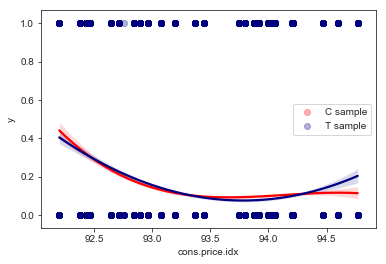

In [241]:
sns.regplot(x="cons.price.idx", y="y", order=3, data=data_C, truncate=True, scatter_kws={'alpha':0.3}, color = 'red', label = "C sample")
sns.regplot(x="cons.price.idx", y="y", order=3, data=data_T, truncate=True, scatter_kws={'alpha':0.3}, color = 'navy', label = "T sample")
plt.legend()

## Consumer confidence index

Clients with extreme price indexes are more likely to buy the credit card.

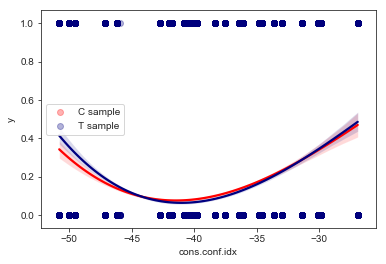

In [242]:
sns.regplot(x="cons.conf.idx", y="y", order=3, data=data_C, truncate=True, scatter_kws={'alpha':0.3}, color = 'red', label = "C sample")
sns.regplot(x="cons.conf.idx", y="y", order=3, data=data_T, truncate=True, scatter_kws={'alpha':0.3}, color = 'navy', label = "T sample")
plt.legend()

### Month

The most promising months are definitely Oct, Sep, Mar, Dec. The worse month is May. 

Why so many calls in May? This is something else that I would ask to the marketing office.

In [202]:
print("T sample")
pd.crosstab(data_T['month'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )


T sample


y,0,1
month,,
mar,0.438735,0.561265
dec,0.530120,0.469880
oct,0.537445,0.462555
sep,0.551829,0.448171
apr,0.767372,0.232628
jun,0.877141,0.122859
nov,0.883436,0.116564
aug,0.886662,0.113338
jul,0.907900,0.092100


Text(0.5, 1.0, 'T sample; Distribution of "month"')

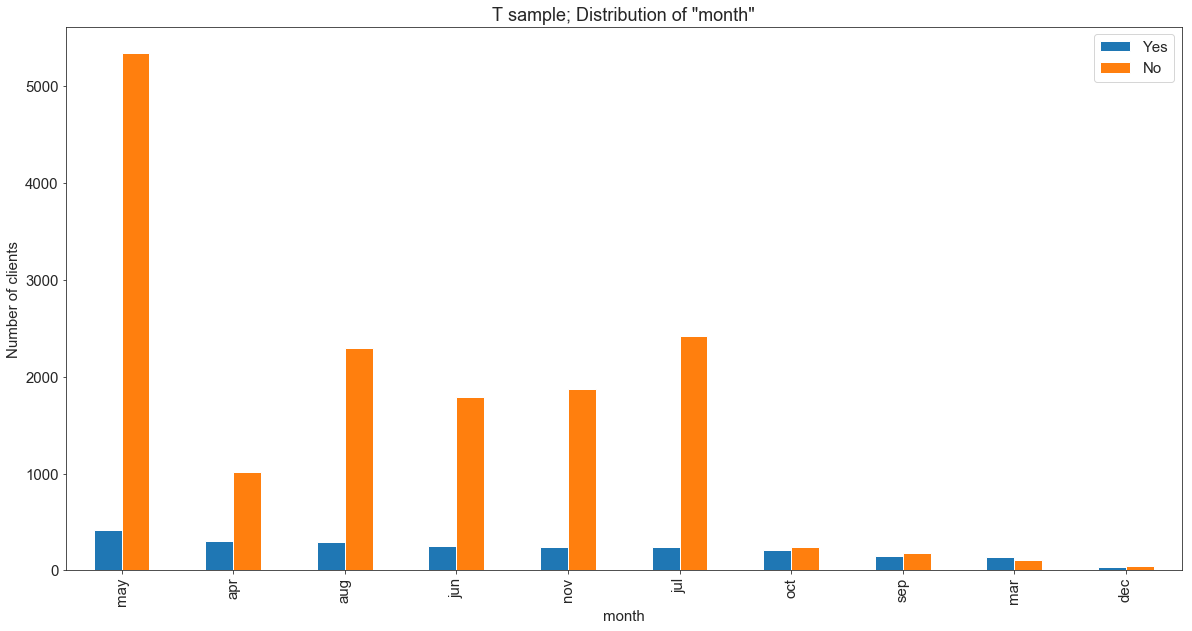

In [218]:
column = 'month'
temp_1 = pd.DataFrame()
temp_1['Yes'] = data_T[data_T['y'] == 1][column].value_counts()
temp_1['No'] = data_T[data_T['y'] == 0][column].value_counts()
temp_1.plot(kind='bar', figsize=(20,10))
plt.xlabel(f'{column}')
plt.ylabel('Number of clients')
plt.title('T sample; Distribution of "{}"'.format(column))


### Day of the week

I cannot see clear relations between the feature and the target.

In [219]:
print("T sample")
pd.crosstab(data_T['day_of_week'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )


T sample


y,0,1
day_of_week,,
tue,0.862888,0.137112
wed,0.864600,0.135400
thu,0.865342,0.134658
fri,0.876285,0.123715
mon,0.882243,0.117757


Text(0.5, 1.0, 'T sample; Distribution of "day_of_week"')

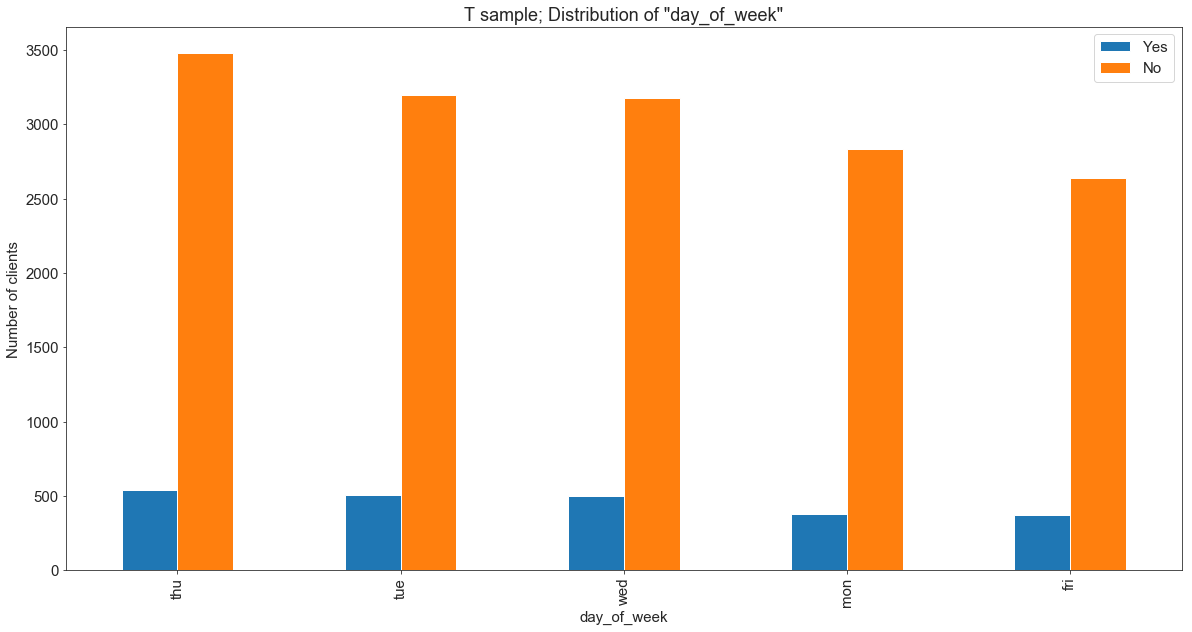

In [220]:
column = 'day_of_week'
temp_1 = pd.DataFrame()
temp_1['Yes'] = data_T[data_T['y'] == 1][column].value_counts()
temp_1['No'] = data_T[data_T['y'] == 0][column].value_counts()
temp_1.plot(kind='bar', figsize=(20,10))
plt.xlabel(f'{column}')
plt.ylabel('Number of clients')
plt.title('T sample; Distribution of "{}"'.format(column))


### Number of contacts

Clients must be contacted via cellular.

In [221]:
print("T sample")
pd.crosstab(data_T['contact'], data_T['y'], normalize='index').sort_values(by=1,ascending=False )


T sample


y,0,1
contact,,
cellular,0.834340,0.165660
telephone,0.940136,0.059864


Text(0.5, 1.0, 'T sample; Distribution of "contact"')

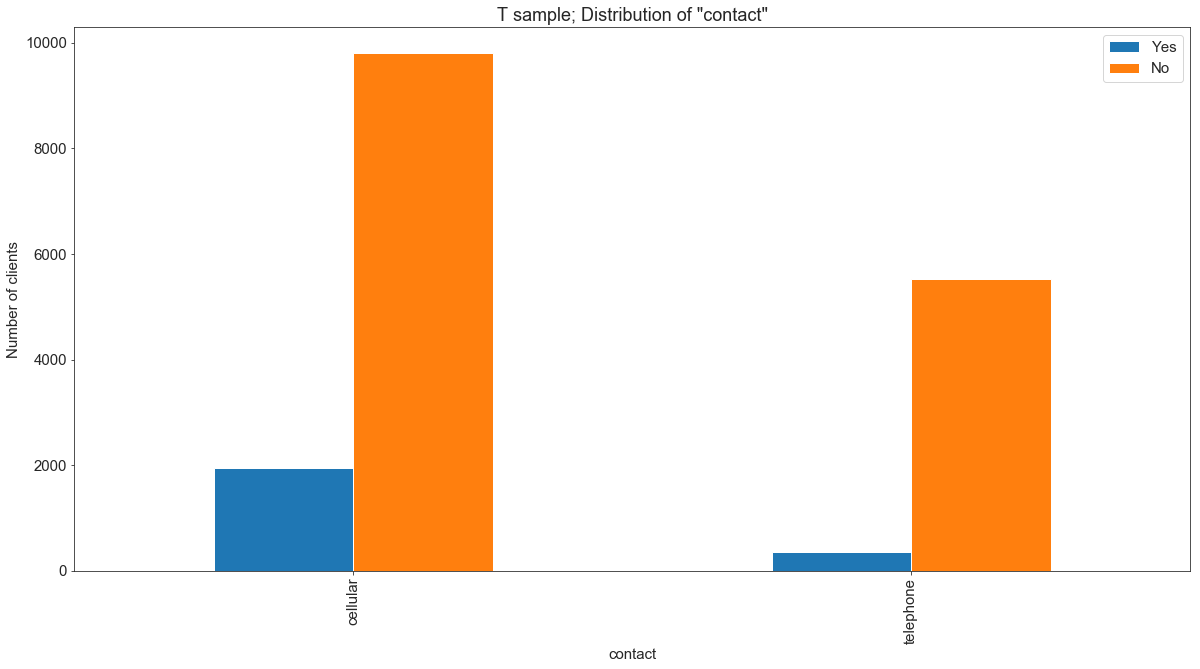

In [222]:
column = 'contact'
temp_1 = pd.DataFrame()
temp_1['Yes'] = data_T[data_T['y'] == 1][column].value_counts()
temp_1['No'] = data_T[data_T['y'] == 0][column].value_counts()
temp_1.plot(kind='bar', figsize=(20,10))
plt.xlabel(f'{column}')
plt.ylabel('Number of clients')
plt.title('T sample; Distribution of "{}"'.format(column))


### Phone call duration

Apart from the few outliers with very high duration values, there is a clear relation between the feature and the target variable. I suspect that this is data leakage: naturally the phone call lasts a lot if the client is potentially interested. Since the goal of my analysis is to identify the potential buyers before calling them, I won't use this feature to build the models.

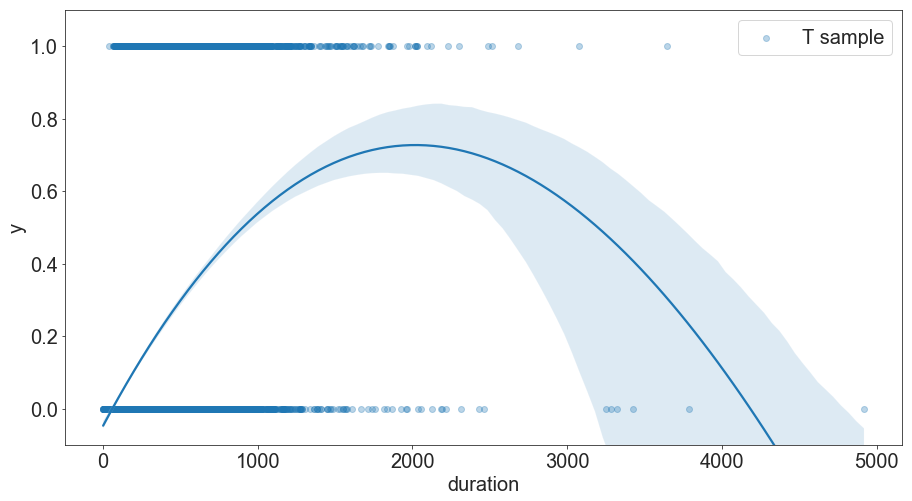

In [248]:
plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 20})
sns.regplot(x="duration", y="y", order=3, data=data_T, truncate=True, scatter_kws={'alpha':0.3}, label = "T sample")
plt.ylim([-0.1,1.1])
plt.legend()

## Correlation matrix

If we exclude the "duration" feature (data leakage), there are not strong correlations between features.

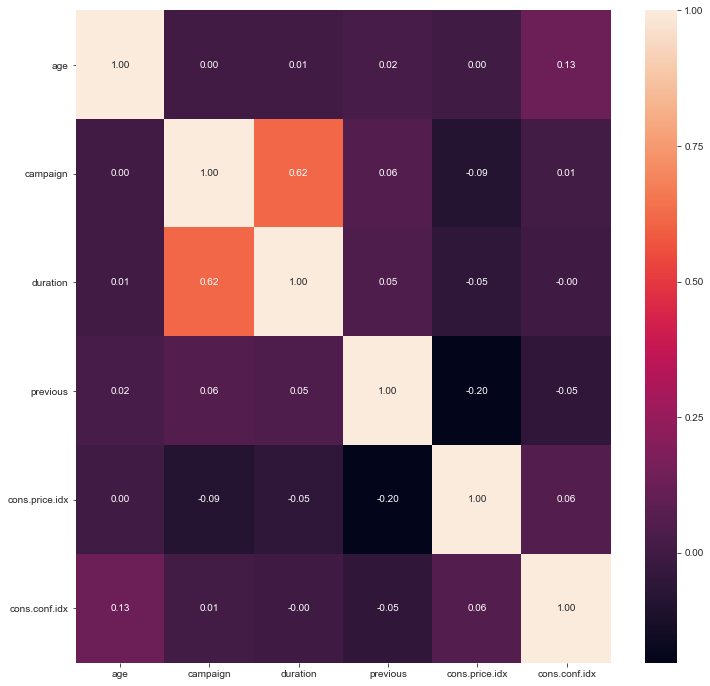

In [236]:
numerical_columns = list(data._get_numeric_data().keys())[0:6]

plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 10})
ax = sns.heatmap(data[numerical_columns].corr(), annot=True, fmt='.2f')
ax.set_yticklabels(numerical_columns, rotation=0, ha='right', minor=False);
